# USD/JPY LSTM(TensorFlow)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set()

## データ読み込み

In [2]:
df = pd.read_csv('data/usd_jpy.csv')
df.head()

,日付,始値,高値,安値,終値
0,2007/04/02,117.84,118.08,117.46,117.84
1,2007/04/03,117.84,118.98,117.72,118.96
2,2007/04/04,118.92,119.08,118.56,118.72
3,2007/04/05,118.72,118.99,118.44,118.72
4,2007/04/06,118.72,119.39,118.67,119.27


In [3]:
df.describe()

,始値,高値,安値,終値
count,2925.000000,2925.000000,2925.000000,2925.000000
mean,100.618236,101.057046,100.119538,100.615289
std,13.849288,13.881241,13.800449,13.851496
min,75.760000,75.980000,75.570000,75.680000
25%,89.690000,90.210000,89.120000,89.740000
50%,102.080000,102.440000,101.720000,102.090000
75%,111.700000,112.140000,111.170000,111.700000
max,125.660000,125.860000,124.540000,125.550000


([<matplotlib.axis.XTick at 0x10303bf60>,
 <a list of 12 Text xticklabel objects>)

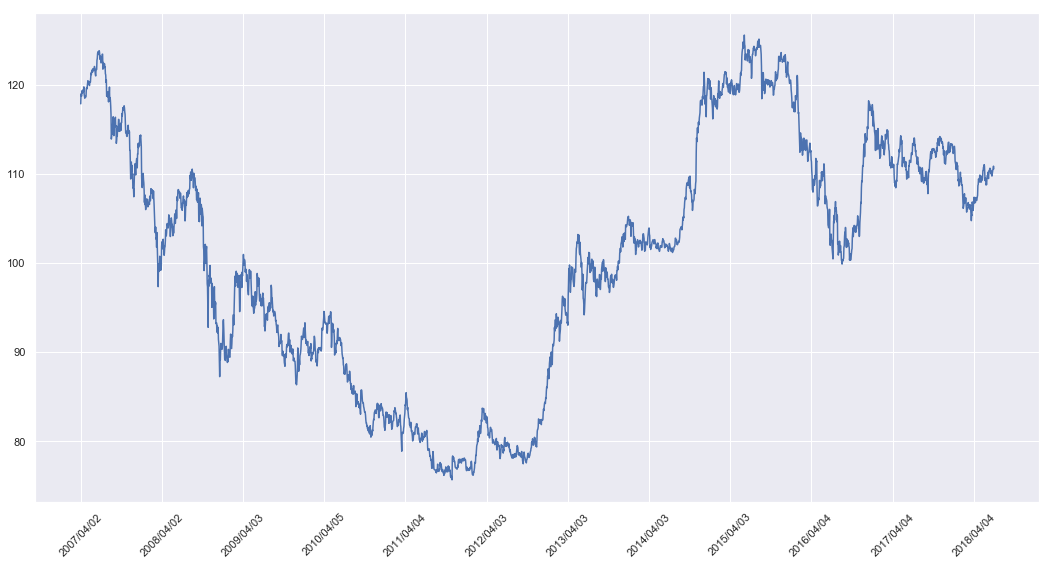

In [4]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(df.shape[0]), df['終値'].values)
plt.xticks(np.arange(0, df.shape[0], 260), df['日付'].loc[::260], rotation=45)

In [5]:
close_prices = df['終値'].values

train_ratio = 0.8
n_train = int(len(close_prices) * train_ratio)
train, test = close_prices[:n_train], close_prices[n_train:]
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

In [6]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [7]:
class DataGenerator():
    def __init__(self, data, batch_size, n_steps):
        self.data = data
        self.batch_size = batch_size
        self.n_steps = n_steps
        
        self.i = 0
        self.epoch = 0
        self.new_epoch = False
        
        self.perm = np.random.permutation(len(data) - self.n_steps)
    
    def next_batch(self):
        if self.new_epoch:
            self.new_epoch = False

        batch = []
        for _ in range(self.batch_size):
            self.i += 1
            if self.i >= len(self.perm):
                self.i %= len(self.perm)
                self.epoch += 1
                self.new_epoch = True

            idx = self.perm[self.i]
            batch.append(self.data[idx: idx+self.n_steps+1])
        batch = np.array(batch)
        return batch[:, :-1], batch[:, -1]  # x, y

In [8]:
# 学習設定
batch_size = 32    # ミニバッチサイズ
n_steps = 50       # 入力系列の長さ
input_size = 1     # 入力の次元
hidden_size = 50   #  中間層の次元
output_size = 1    # 出力層の次元

n_epochs = 30       # エポック数

In [9]:
train_gen = DataGenerator(train, batch_size, n_steps)

## モデル構築

In [10]:
def inference(x):
    """
    推論（順伝播）
    x: (batch_size, n_steps, input_size)
    """
    # static_rnn関数の引数に適切な形に変形
    x = tf.transpose(x, [1, 0, 2])  # (n_steps, batch_size, input_size)
    x = tf.reshape(x, [-1, input_size])  # (n_steps*batch_size, input_size)
    x = tf.split(x, n_steps, axis=0)  # [(batch_size, input_size)] * n_steps
    
    # RNN(LSTM)セルを定義
    rnn_cell = tf.contrib.rnn.BasicRNNCell(hidden_size)
#     rnn_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size, forget_bias=1.0)
    
    # RNNセルを時間方向に伝播
    hs, _ = tf.contrib.rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    
    # 出力層の定義
    W_out = tf.Variable(tf.random_normal([hidden_size, output_size]))
    b_out = tf.Variable(tf.random_normal([output_size]))
    return tf.matmul(hs[-1], W_out) + b_out

In [11]:
tf.reset_default_graph()

# 入出力プレースホルダーの定義
x = tf.placeholder("float", [None, n_steps, input_size])
y = tf.placeholder("float", [None, output_size])

# オペレーションの定義
pred = inference(x)
loss = tf.losses.mean_squared_error(y, pred)
train_step = tf.train.AdamOptimizer().minimize(loss)

## 学習

In [12]:
init = tf.global_variables_initializer()
# セッション
sess = tf.Session()
# 変数初期化
sess.run(init)

while train_gen.epoch < n_epochs:
    batch_x, batch_y = train_gen.next_batch()
    feed_dict = {x: batch_x, y: batch_y}
    sess.run(train_step, feed_dict=feed_dict)
    if train_gen.new_epoch:
        l = sess.run(loss, feed_dict=feed_dict)
        print("epoch: {}, loss {:.5f}".format(train_gen.epoch, l))

epoch: 1, loss 0.00795
epoch: 2, loss 0.00421
epoch: 3, loss 0.00267
epoch: 4, loss 0.00226
epoch: 5, loss 0.00240
epoch: 6, loss 0.00206
epoch: 7, loss 0.00160
epoch: 8, loss 0.00212
epoch: 9, loss 0.00179
epoch: 10, loss 0.00188
epoch: 11, loss 0.00154
epoch: 12, loss 0.00159
epoch: 13, loss 0.00137
epoch: 14, loss 0.00127
epoch: 15, loss 0.00138
epoch: 16, loss 0.00118
epoch: 17, loss 0.00129
epoch: 18, loss 0.00124
epoch: 19, loss 0.00131
epoch: 20, loss 0.00133
epoch: 21, loss 0.00151
epoch: 22, loss 0.00102
epoch: 23, loss 0.00101
epoch: 24, loss 0.00096
epoch: 25, loss 0.00087
epoch: 26, loss 0.00101
epoch: 27, loss 0.00084
epoch: 28, loss 0.00089
epoch: 29, loss 0.00090
epoch: 30, loss 0.00080


## テスト

In [13]:
test_batch = []
for idx in range(len(test) - n_steps):
    test_batch.append(test[idx: idx+n_steps+1])
test_batch = np.array(test_batch)
x_test, y_test = test_batch[:, :-1], test_batch[:, -1]

In [14]:
# テストデータに対する予測
prediction = sess.run(pred, feed_dict={x: x_test})

prediction = prediction.reshape(-1, 1)
# 元のスケールに
prediction = scaler.inverse_transform(prediction)
y_test = scaler.inverse_transform(y_test)

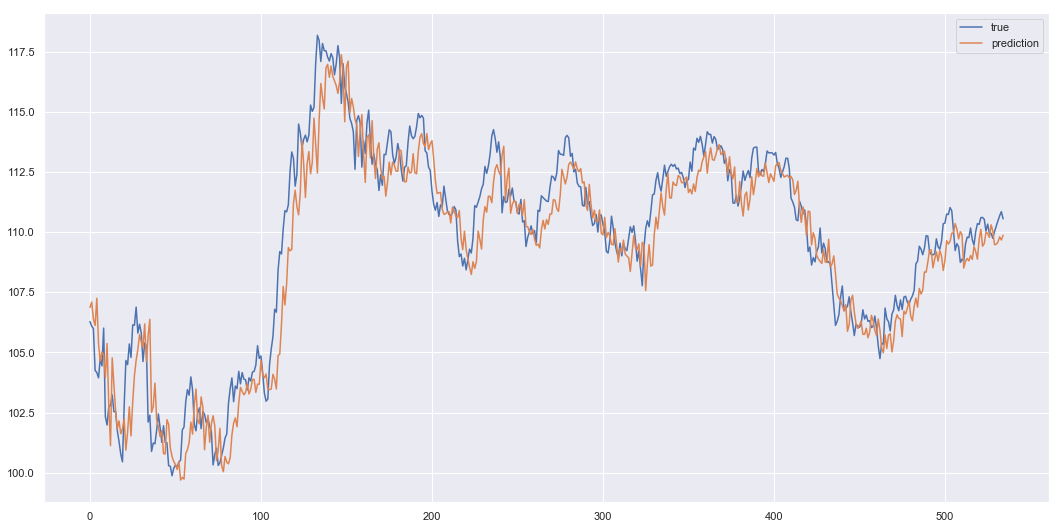

In [15]:
# テストデータに対する予測を可視化
xx = np.arange(len(prediction))
plt.figure(figsize=(18, 9))
plt.plot(xx, y_test, label='true')
plt.plot(xx, prediction, label='prediction')
plt.legend()